## Set up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_regression_pipelines, categorical_input_columns, pipelines , reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, view_as_exponential, view_decision_tree_julian, view_linear_model_richard

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
load_process_and_store_spreadsheets(transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Overall survival and progression free survival
### Population results
To first get an idea of the overall factors, we have a brief look at the data as a whole.

In [4]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

First calculate distribution of the overall survival (OS) and progression free survival (PFS) and the cumulative distribution.

In [5]:
# Calculate the distribution and cumulative distribution for:
# 1) overall survival.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)
# 2) progression free survival.
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'], hist_bins=10, cum_hist_bins=15)

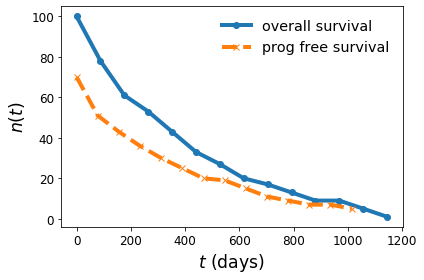

In [6]:
plt.figure()
plt.plot(t_OS_cum, p_OS_cum, '-o', label='overall survival')
plt.plot(t_PFS_cum, p_PFS_cum, '--x', label='prog free survival')
plt.xlabel('$t$ (days)')
plt.ylabel('$n(t)$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


(-22.88, 1166.88)

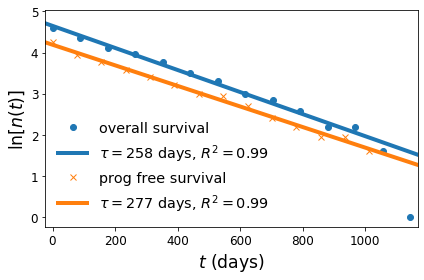

In [7]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers, markers=['o', '-'], label='overall survival')
view_as_exponential(t_PFS_cum, p_PFS_cum, markers=['x', '-'], label='prog free survival')
plt.gca()
dt = t_OS_cum[-1] - t_OS_cum[0]
plt.xlim([t_OS_cum[0] - 0.02*dt, t_OS_cum[-1] + 0.02*dt])

### Phenotype differences
Two exponentials form approximately an exponential
$$
\frac{n_1}{N} e^{-\alpha_1 t} + \frac{n_2}{N} e^{-\alpha_2 t} \approx \exp\left(-\frac{n_1}{N}\alpha_1 t - \frac{n_2}{N}\alpha_2t \right) \equiv \exp(-\alpha t) ,
$$
with $N=n_1 + n_2$, when $n_2(\alpha_1 - \alpha_2)/N t \ll 1$ for relevant $t$. That is, our new $\alpha$ is a weighted average of the individual ones.

In [8]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [9]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)
effect_summary

            tau  sigma_t    n         r
all     216.837  305.877  125 -0.950032
male    226.781  307.094   70 -0.975415
female  268.355  303.974   55 -0.995173
         tau  sigma_t    n         r
all  216.837  305.877  125 -0.950032
4    228.295  314.694  109 -0.943583
3    300.838  232.724   16 -0.971683
             tau  sigma_t    n         r
all      216.837  305.877  125 -0.950032
2        280.016  309.764   83 -0.997873
1+3+0+4  245.406  293.996   42 -0.990076
                        tau  sigma_t    n         r
all                 216.837  305.877  125 -0.950032
smoker              329.657  340.062   75 -0.997976
previous            202.735  253.249   38 -0.974226
unknown+non smoker  162.877  184.802   12 -0.969192
                                                        tau  sigma_t    n  \
all                                                 216.837  305.877  125   
pembrolizumab+nivolumab + ipilimumab+atezolizum...  199.093  241.253   22   
nivolumab                            

delta tau  \
category            item                                                             
gender              male-female                                          41.573833   
stage               4-3                                                  72.542822   
therapyline         2-1+3+0+4                                            34.609658   
smokingstatus       smoker-previous                                     126.921462   
                    smoker-unknown+non smoker                           166.779831   
                    previous-unknown+non smoker                          39.858369   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...   40.112911   
histology_grouped   adeno-squamous                                       30.270218   
                    adeno-other                                          70.383545   
                    squamous-other                                      100.653763   
lymfmeta            metastasis present-no metastasis present            111.699710   
brainmeta           metastasis present-no metastasis present             33.175529   
adrenalmeta         no metastasis present-metastasis present             41.995421   
livermeta           no metastasis present-metastasis present             51.224007   
lungmeta            no metastasis present-metastasis present             19.664026   
skeletonmeta        no metastasis present-metastasis present              2.896052   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.135917  
stage               4-3                                                        0.237163  
therapyline         2-1+3+0+4                                                  0.113149  
smokingstatus       smoker-previous                                            0.414943  
                    smoker-unknown+non smoker                                  0.545251  
                    previous-unknown+non smoker                                0.130308  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...         0.131141  
histology_grouped   adeno-squamous                                             0.098962  
                    adeno-other                                                0.230104  
                    squamous-other                                             0.329066  
lymfmeta            metastasis present-no metastasis present                   0.365178  
brainmeta           metastasis present-no metastasis present                   0.108460  
adrenalmeta         no metastasis present-metastasis present                   0.137295  
livermeta           no metastasis present-metastasis present                   0.167466  
lungmeta            no metastasis present-metastasis present                   0.064287  
skeletonmeta        no metastasis present-metastasis present                   0.009468

In [10]:
effect_summary = categorical_signal_summary(X, y['PFS_days'], categorical_input_columns)
effect_summary

            tau  sigma_t    n         r
all     276.787  288.051  125  -0.99686
male    248.267  285.572   70  -0.98568
female  325.124  291.007   55 -0.968379
         tau  sigma_t    n         r
all  276.787  288.051  125  -0.99686
4    295.744  299.182  109 -0.997666
3    206.752   188.43   16 -0.939819
             tau  sigma_t    n         r
all      276.787  288.051  125  -0.99686
2        299.492  304.922   83 -0.995434
1+3+0+4  232.182  239.536   42 -0.966498
                        tau  sigma_t    n         r
all                 276.787  288.051  125  -0.99686
smoker              320.702  325.932   75 -0.992847
previous            192.095  201.311   38 -0.971297
unknown+non smoker   231.48  192.649   12 -0.853656
                                                        tau  sigma_t    n  \
all                                                 276.787  288.051  125   
pembrolizumab+nivolumab + ipilimumab+atezolizum...  192.161  254.703   22   
nivolumab                            

delta tau  \
category            item                                                              
gender              male-female                                           76.857223   
stage               4-3                                                   88.992372   
therapyline         2-1+3+0+4                                             67.309618   
smokingstatus       smoker-previous                                      128.607674   
                    smoker-unknown+non smoker                             89.222131   
                    previous-unknown+non smoker                           39.385543   
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...   120.587861   
histology_grouped   adeno-squamous                                       120.550463   
                    adeno-other                                          919.561238   
                    squamous-other                                      1040.111701   
lymfmeta            metastasis present-no metastasis present              58.361391   
brainmeta           metastasis present-no metastasis present             124.986322   
adrenalmeta         no metastasis present-metastasis present              20.847962   
livermeta           no metastasis present-metastasis present              74.120479   
lungmeta            no metastasis present-metastasis present             135.486915   
skeletonmeta        no metastasis present-metastasis present             138.435099   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.266818  
stage               4-3                                                        0.308947  
therapyline         2-1+3+0+4                                                  0.233673  
smokingstatus       smoker-previous                                            0.446476  
                    smoker-unknown+non smoker                                  0.309744  
                    previous-unknown+non smoker                                0.136731  
Systemischetherapie pembrolizumab+nivolumab + ipilimumab+atezolizum...         0.418634  
histology_grouped   adeno-squamous                                             0.418504  
                    adeno-other                                                3.192357  
                    squamous-other                                             3.610861  
lymfmeta            metastasis present-no metastasis present                   0.202608  
brainmeta           metastasis present-no metastasis present                   0.433904  
adrenalmeta         no metastasis present-metastasis present                   0.072376  
livermeta           no metastasis present-metastasis present                   0.257317  
lungmeta            no metastasis present-metastasis present                   0.470358  
skeletonmeta        no metastasis present-metastasis present                   0.480593

### Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
A model should at least be able to out perform the following mean squared error:
$$
\Delta e^2 = \frac{1}{N}\left(n_1 \frac{{\tau_1}^2}{\ln^2 2} + n_2 \frac{{\tau_2}^2}{\ln^2 2} \right) \, .
$$

Using the value above $\tau =258$ days gives a variance of

### Tuning the pipeline
We use a variety of different pipelines and different algorithms to try to squeeze as much signal from the data as possible. Let us focus on the overall survival first.

In [11]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)

Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

In [12]:
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,331.221847,255.227153,381.503252,269.618643
RandomForestRegressor,321.659853,289.205408,287.635103,290.898249
GradientBoostingRegressor,289.469174,266.030076,302.617991,268.450157
KNeighborsRegressor,375.229392,289.899266,367.328402,313.401862
ElasticNet,259.423289,271.744500,273.215056,263.350630
LinearRegression,261.651308,260.780187,1942.032904,251.282592
SVR,277.045767,276.105578,277.044043,276.572572
DummyRegressor,277.072810,277.072810,277.072810,277.072810


The data indicates that the linear regression model with the `Lev` pipeline (which combines the `Richard` and `Julian` pipelines) gives the best results.

- $\Delta \tau$ 
- Calculation of $\Delta \tau$ for various phenotypes.
- Tuning of pipeline.
- Somatic vs all
- Hybrid model best performance.
### Decypher effects of input features

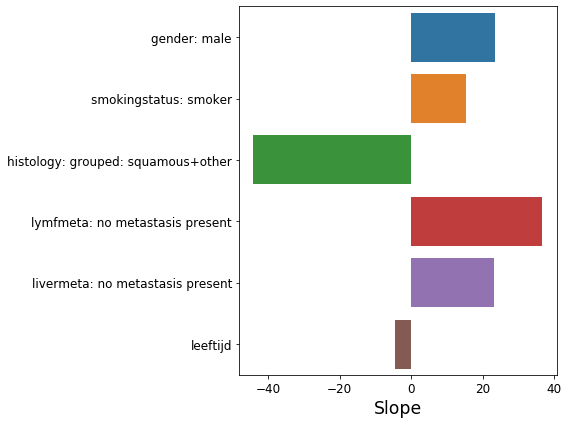

In [13]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(pipeline=p_richard)

[  877.64872895 -4254.81450895 -2208.68702016 -1412.03049931
 -8561.2355162 ]


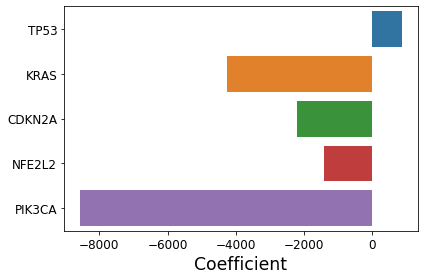

In [15]:
p_julian = pipelines['LinearRegression']['Julian']
classifier = p_julian.steps[-1][1]
column_names = p_julian.steps[-2][1].columns_to_keep_
print(classifier.coef_)
with sns.plotting_context(font_scale=1.5):
#     plt.figure(figsize=(14, 6))
    plt.xlabel(r"Coefficient")
    sns.barplot(x=classifier.coef_, y=column_names, label="large")
    plt.tight_layout()


The sheer size of the coefficients are related to the size of the input variables (which are calculated using the harmonic mean). But the positive sign of `TP53` indicates that the presence of this variable is indicative for prolonger survival.

## Classification
- Tuning of pipeline.
- Precision, recall, $F_1$ and ROC AUC.
- Confusion matrix.
- Somatic vs. all.
- Best model.
- Decypher effects.